In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import seaborn as sns
import os
import numpy as np
import matplotlib.patches as mpatches

In [18]:
# read in data from system
df = pd.read_excel("all_reports.xlsx")

In [19]:
# remove rows that are no transaction matched or error ss did not fail
df = df[df['Bucket Category'] != 'ERROR_no_transaction_matched']
df = df[df['Bucket Category'] != 'ERROR_SS_did_not_fail']

# change addcredit_aa to addcredit
df['Transaction'] = df['Transaction'].replace('addcredit_aa', 'addcredit')

# create concatenated column of transaction and bucket category
df['Concatenated'] = df['Transaction'] + '-' + df['Bucket Category']

In [20]:
# merge for transaction and bucket column
list_df = pd.read_excel('transaction_to_tag.xlsx', sheet_name='Final List')

df = pd.merge(df, list_df[['Concatenated', 'Final Test']],
                                 on='Concatenated', how='left')

print(f"Shape before removing other buckets: {df.shape}")
# remove rows where Final Test List is other, now only tests that fit a bucket
df = df[df['Final Test'] != 'other']
print(f"Shape after removing other buckets: {df.shape}")

Shape before removing other buckets: (428, 16)
Shape after removing other buckets: (381, 16)


In [21]:
requirements_df = pd.read_excel('transaction_to_tag.xlsx', sheet_name='List of Tests')

# add in requirements column
df = pd.merge(df, requirements_df[['Final Test', 'In requirements']],
                                 on='Final Test', how='left')
df['In requirements'] = df['In requirements'].astype(bool)

# add happy path column
df['happy_path'] = df['Final Test'].str.contains('success', case=False, na=False)

null_counts = df.isnull().sum()

In [22]:
# remove happy path tests for number of groups vs. requirement chart
df_no_happy = df[~df['happy_path']]

# group requirements by project title
requirements_per_group = df_no_happy[df_no_happy['In requirements']].groupby('Project Title').size()

# get counts by final test, requirements and title
requirements_per_test = df_no_happy.groupby(['Final Test', 'In requirements', 'Project Title'])['Final Test'].count().reset_index(name='Count')

# get counts for number of project titles per final test buckets and in requirements
agg_df = requirements_per_test.groupby(['Final Test','In requirements']).agg(Num_Project_Titles=('Project Title', 'nunique'),
                                     Total_Count=('Count', 'sum')).reset_index()

# get the last word for sorting
agg_df['Last Word'] = agg_df['Final Test'].apply(lambda x: x.split('_')[-1])

# sort by requirements, number of groups and then last word
df_sorted = agg_df.sort_values(by=['In requirements', 'Num_Project_Titles', 'Last Word'])

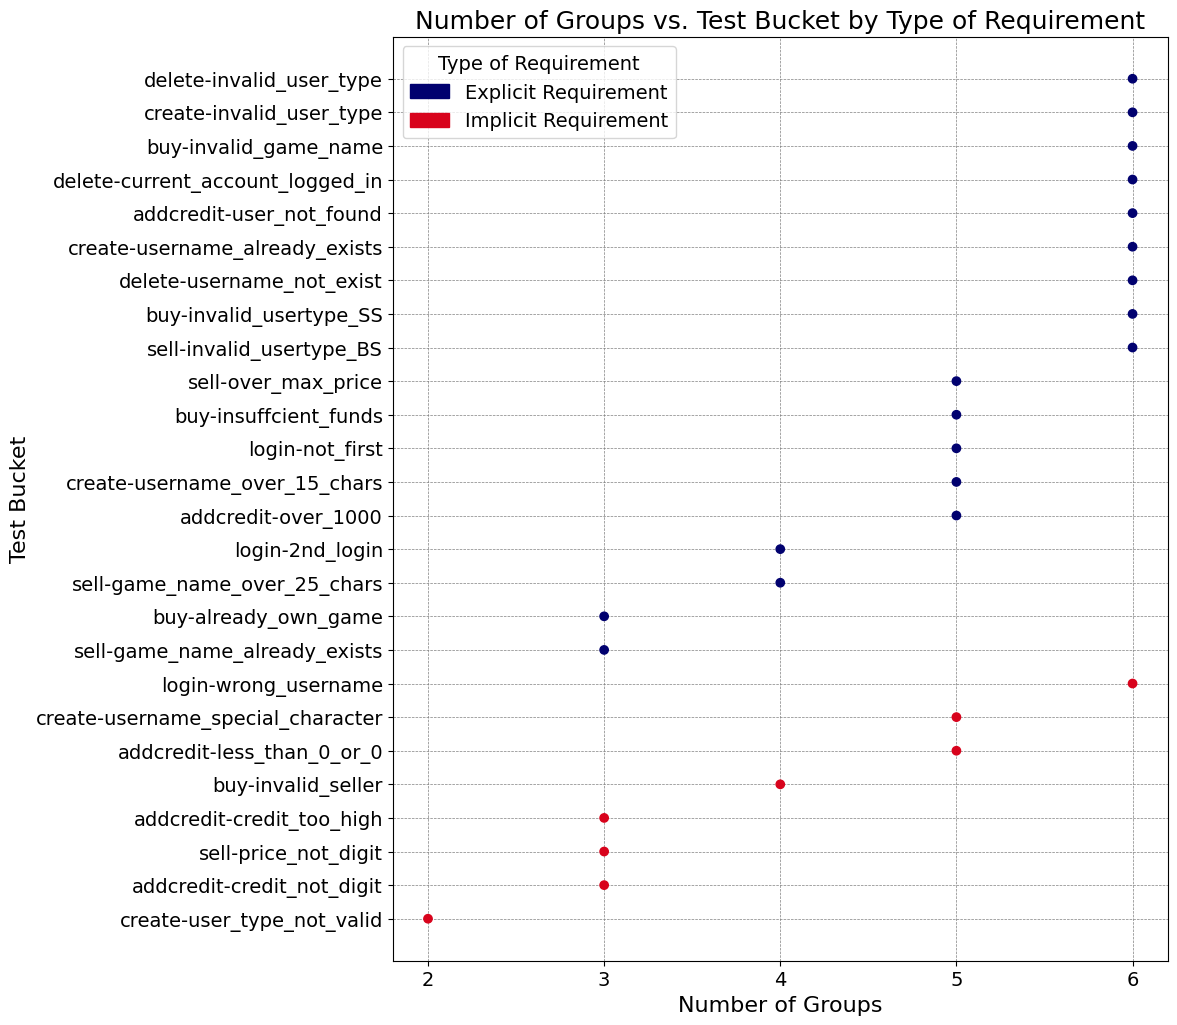

In [28]:
# IMPORTANT NOTE, DOES NOT CONTAIN HAPPY PATH

# set colours for explicit vs implicit requirements
colors = df_sorted['In requirements'].map({True: "#01016f", False: "#d8031c"})

# create plot
plt.figure(figsize=(10, 12))
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', axis='both')
plt.gca().set_axisbelow(True)
plt.scatter(df_sorted['Num_Project_Titles'], df_sorted['Final Test'], c=colors)

# add labels to plot
plt.xticks(ticks=range(2,7,1), fontsize=14)
plt.xlabel('Number of Groups', fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('Test Bucket', fontsize=16)
plt.title('Number of Groups vs. Test Bucket by Type of Requirement', fontsize=18)

# set colours for legend
ex_patch = mpatches.Patch(color="#01016f", label='Explicit Requirement')
im_patch = mpatches.Patch(color="#d8031c", label='Implicit Requirement')

# add legend to plot
plt.legend(handles=[ex_patch, im_patch], loc='upper left', title='Type of Requirement', title_fontsize=14, fontsize=14)

In [24]:
# next 3 graphs have similar plots, so created functions
def create_pivot(pivot_col):
    pivot_df = df.copy()
    pivot_df[pivot_col] = pivot_df[pivot_col].astype(str)
    intermediate_df = pivot_df.groupby(['Project Title', 'Final Test', pivot_col]).size().reset_index(name='Count')

    # Pivot this DataFrame to get 'Final Test' and 'Happy Path' combinations as columns
    pivot_df = intermediate_df.pivot_table(index=['Project Title', pivot_col], 
                                        columns='Final Test', 
                                        values='Count', 
                                        fill_value=0)
    
    return pivot_df
    
def create_dataframe_from_pivot(pivot_df):
    # get transpose of pivot
    test_counts_transpose = pivot_df.T

    # get sum count for bucket tests and total tests
    non_zero_counts = (test_counts_transpose != 0).sum(axis=0)
    column_sums = test_counts_transpose.sum(axis=0)

    # create dataframe with sums
    summary_df = pd.DataFrame({
        'Bucket Tests': non_zero_counts,
        'Total Tests': column_sums
    })

    # reset index from project title
    summary_df = summary_df.reset_index()

    # get shorted title for plot and number of duplicate tests
    summary_df['Shortened Title'] = summary_df['Project Title'].apply(lambda x: x[-2:])
    summary_df["Duplicate Tests"] = summary_df["Total Tests"] - summary_df["Bucket Tests"]

    return summary_df

def create_plot(ax, i, positions, data_df, title, color1, color2, font_title, font_axis, font_label):
    width_bar = 0.35

    # create bar plot
    rects1 = ax.bar(positions - width_bar/2, data_df['Bucket Tests'], width_bar, label='Bucket', color=color1)
    rects2 = ax.bar(positions + width_bar/2, data_df['Duplicate Tests'], width_bar, label='Duplicate', color=color2)

    # set titles/labels
    ax.set_title(title, fontsize=font_title)
    ax.set_xticks(positions)
    ax.set_xticklabels(data_df['Shortened Title'], fontsize=font_label)
    ax.set_xlabel('Group ID', fontsize=font_axis)
    ax.legend(title='Type of Test', fontsize=font_label, title_fontsize=font_axis)
    ax.grid(which='major', linestyle='--', linewidth='0.5', color='grey', axis='y')
    ax.set_axisbelow(True)

    # only include y label on left plot
    if (i == 0):
        ax.tick_params(axis='y', labelsize=font_label)
        ax.set_ylabel('Number of Tests', fontsize=font_axis)

def filter_order_range(df, plot_col, sort_by_col, bool_choice):
    summary = df.copy()

    # create filtered dfs
    filter_df = summary[summary[plot_col] == bool_choice]

    # order by duplicate tests
    df_plot = filter_df.sort_values(by=sort_by_col)

    # create evenly spaced values in range
    positions = np.arange(len(df_plot))
    
    return positions, df_plot

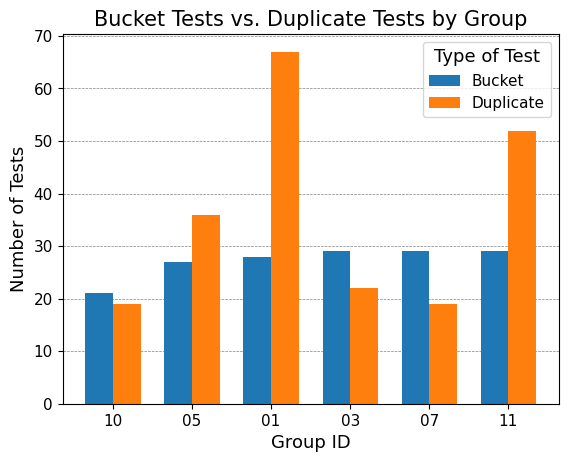

In [25]:
# get counts for number of tests per group that are in final test buckets
test_counts = df.groupby('Project Title')['Final Test'].value_counts().unstack(fill_value=0)

# use pivot function to get df
summary_df = create_dataframe_from_pivot(test_counts)

# sort by bucket tests
sorted_df = summary_df.sort_values(by='Bucket Tests')

# plot bucket tests vs. duplicate tests by group
fig, ax = plt.subplots()
positions = np.arange(len(sorted_df))
create_plot(ax, 0, positions, sorted_df, "Bucket Tests vs. Duplicate Tests by Group", "#1f77b4", "#ff7f0e", 15, 13, 11)

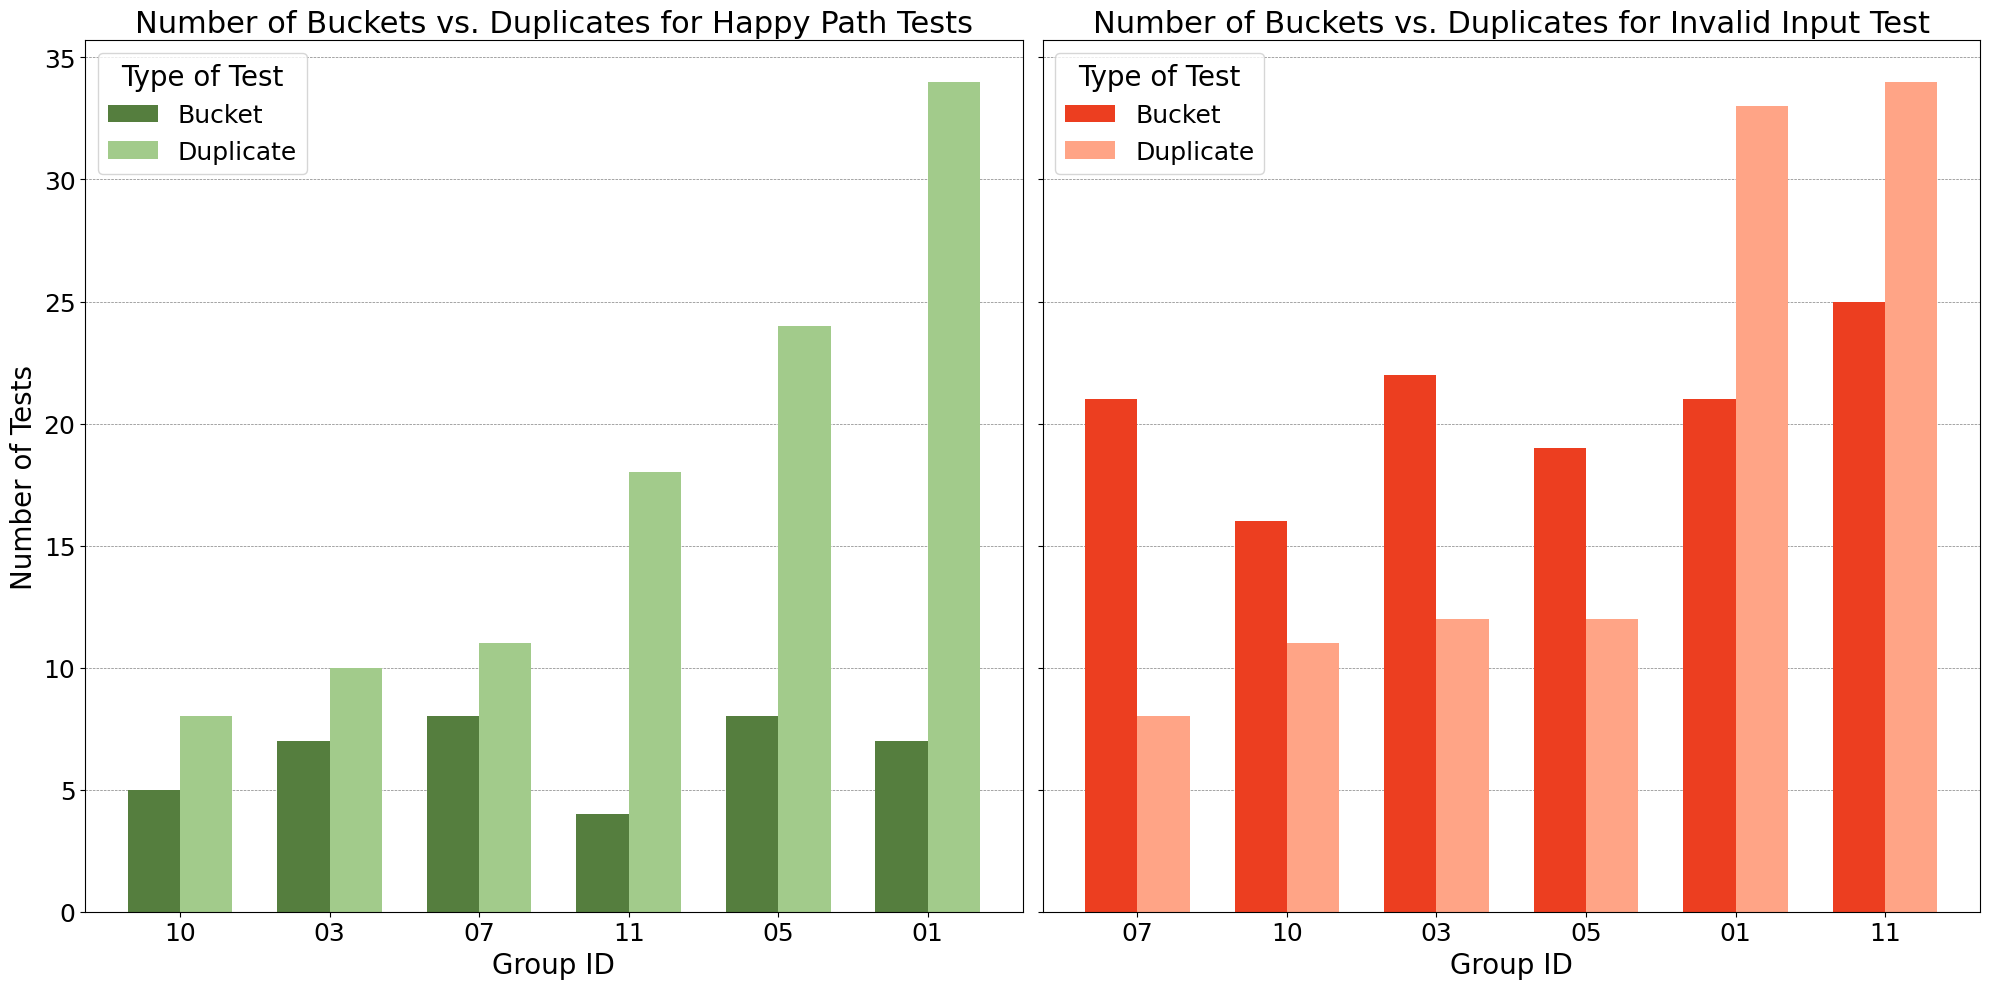

In [26]:
# create df for happy path vs invalid input plots
happy_pivot = create_pivot("happy_path")
happy_df = create_dataframe_from_pivot(happy_pivot)

# get summary counts by project and test bucket
summary_w_counts = (pd.merge(happy_df, test_counts, left_index=True, right_index=True, how='inner'))

# create figure with subplots
fig_happy, axs_happy = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# create plot for happy path side
positions, df_plot = filter_order_range(happy_df, "happy_path", "Duplicate Tests", "True")
create_plot(axs_happy[0], 0, positions, df_plot, "Number of Buckets vs. Duplicates for Happy Path Tests", "#557e3e", "#A2CB8B", 22, 20, 18)

# create plot for invalid input side
positions, df_plot = filter_order_range(happy_df, "happy_path", "Duplicate Tests", "False")
create_plot(axs_happy[1], 1,  positions, df_plot, "Number of Buckets vs. Duplicates for Invalid Input Test", "#ec3e20", "#FFA486", 22, 20, 18)

plt.tight_layout()
plt.show()

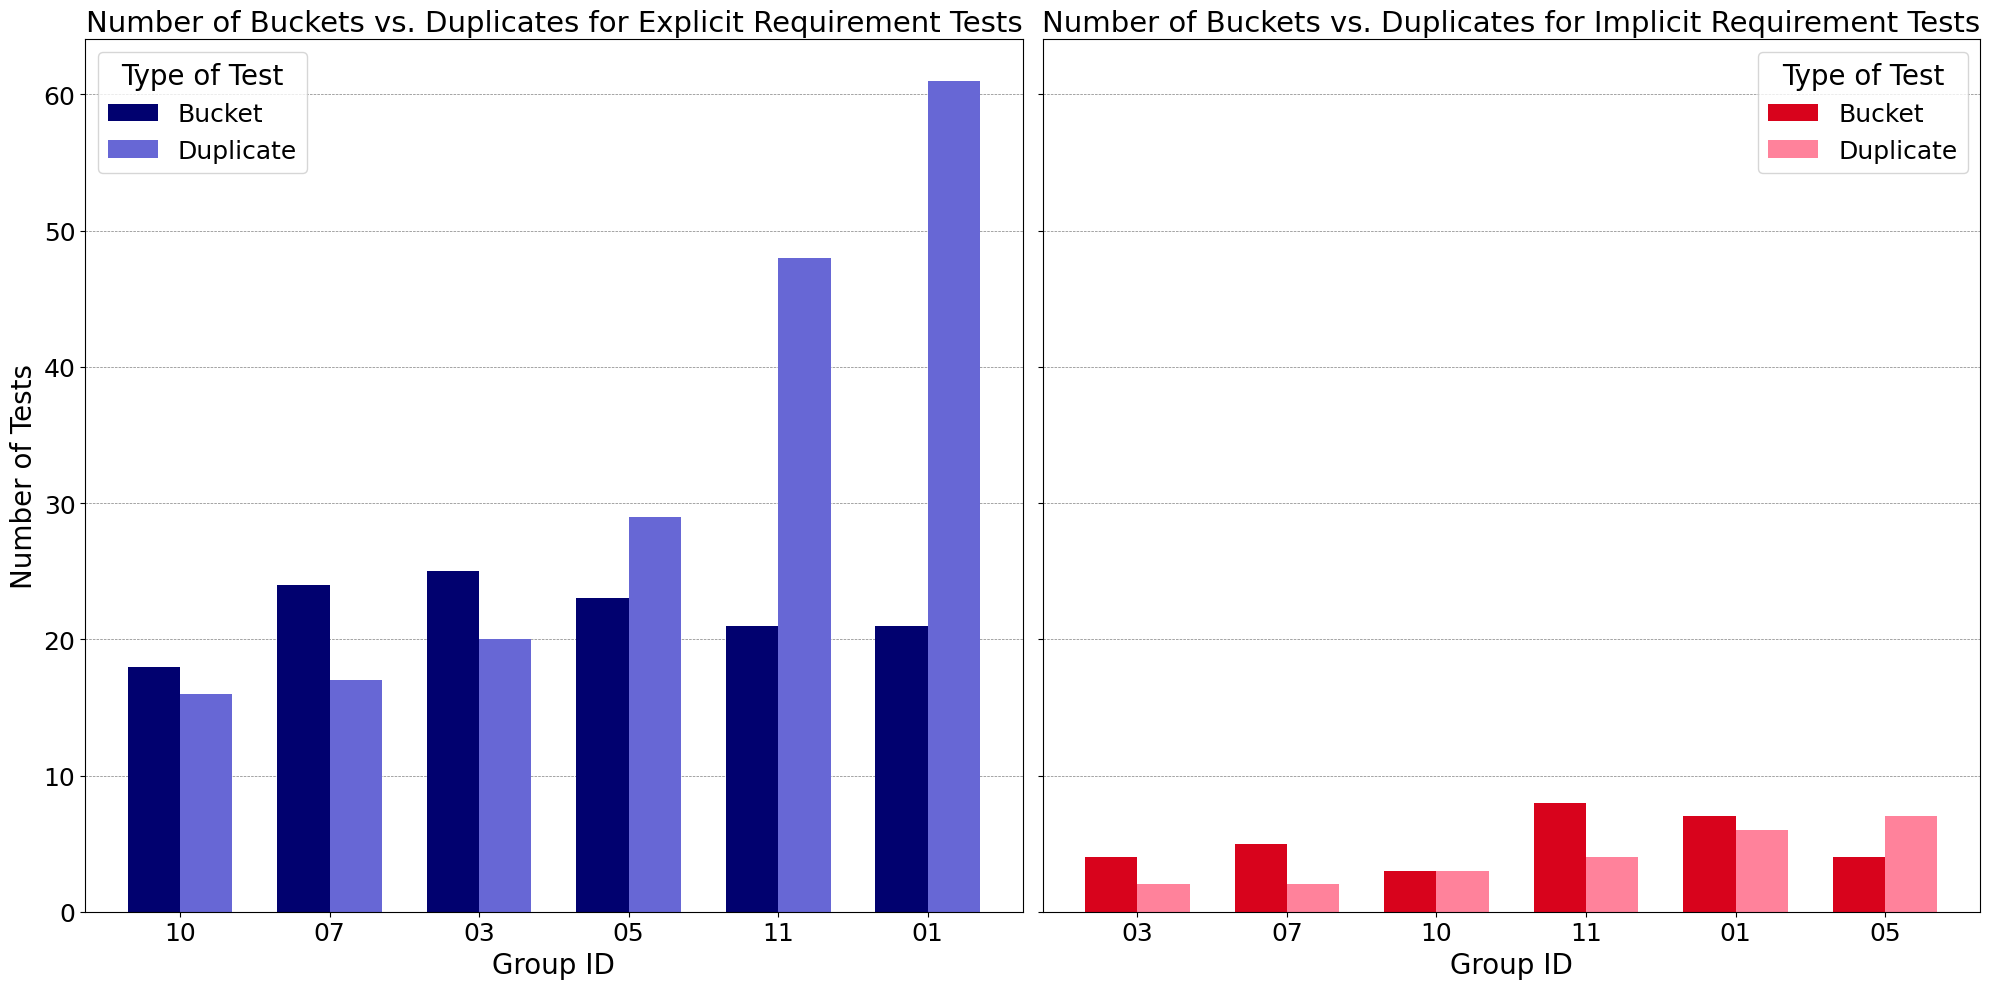

In [27]:
# create df for explicit vs implicit requirement plots
requirement_pivot = create_pivot("In requirements")
requirement_df = create_dataframe_from_pivot(requirement_pivot)

# create figure with subplots
fig_req, axs_req = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# create plot for explicit requirement side
positions_req, df_plot_req = filter_order_range(requirement_df, "In requirements", "Duplicate Tests", "True")
create_plot(axs_req[0], 0, positions_req, df_plot_req, "Number of Buckets vs. Duplicates for Explicit Requirement Tests", "#01016f", "#6767D5", 21, 20, 18)

# create plot for implicit requirement side
positions_req, df_plot = filter_order_range(requirement_df, "In requirements", "Duplicate Tests", "False")
create_plot(axs_req[1], 1,  positions_req, df_plot, "Number of Buckets vs. Duplicates for Implicit Requirement Tests", "#d8031c", "#FF829B", 21, 20, 18)

plt.tight_layout()
plt.show()